<a href="https://colab.research.google.com/github/dodonas/DL_Final_Project_GAN/blob/master/DL_FINAL_PROJECT_Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks - Afeka, Deep Learning
# Final project - Implementing Conditional GANs in Keras

# Submitters

[Andrey Dodon](https://www.kaggle.com/andreydodon) - ID 317858298

[Pazit Lazar](https://il.linkedin.com/in/pazit-lazar-85012272) - ID 204059919

[Erez Mahalu](https://il.linkedin.com/in/erez-mahalu-589388109) - ID 305465619

[Ekaterina Natanov](https://il.linkedin.com/in/ekaterina-natanov-0960135a) - ID 323281758

# References
[Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)<br> 
[Domain Transfer - Weizmann Institute of Science](https://www.wisdom.weizmann.ac.il/~vision/courses/2018_2/Advanced_Topics_in_Computer_Vision/files/DomainTransfer.pdf)


# Short introduction

Regular GAN that generates images using a random latent vector as input.<br>
While it works great we do not know the mapping of latent vector to the generated image.<br> Conditional GANs can be used to supply a label during taining so the latent vector can be associated <br> with a specific label - making the generation of images predictable. 

# Quick reminder
As discussed during the ZOOM presentation, the GAN is made up of two different neural networks: the Discriminator and the Generator.  The generator generates the images, while the discriminator detects if a face is real or was generated.  These two neural networks work as shown below:<br>
![GAN](https://raw.githubusercontent.com/dodonas/DL_Final_Project_GAN/master/data/img/gan_flow.png "GAN architecture")

The discriminator accepts an image as its input and produces number that is the probability of the input image being real.  The generator accepts a random seed vector and generates an image from that random vector seed. An unlimited number of new images can be created by providing additional seeds.

# What is Conditional GAN?

CGAN Generator: G(z, y) = x*|y. Using random noise vector z and label y as inputs,<br> the Generator produces a fake example x*|y that strives to be a realistic-looking match for the label.<br>
![cGAN_generator](https://drek4537l1klr.cloudfront.net/langr/Figures/08fig01.jpg "cGAN generator")

The CGAN Discriminator receives real examples along with their labels (x, y)<br> and fake examples along with the label used to synthesize them (x*|y, y). <br>The Discriminator then outputs a probability (computed by the sigmoid activation function σ) <br>indicating whether the input pair is real rather than fake.

![cGAN_discriminator](https://drek4537l1klr.cloudfront.net/langr/Figures/08fig02_alt.jpg "cGAN discriminator")

# Imports

In [19]:
import numpy as np
import tensorflow as tf
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
%matplotlib inline

# Load data and plot to get a quick understanding

## CIFAR-10
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)<br>
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes,<br> with 6000 images per class.<br> There are 50000 training images and 10000 test images.<br>
CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

170508288/170498071 [==============================] - 4s 0us/step


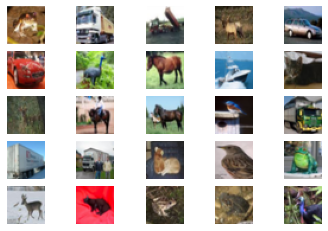

In [2]:
(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

# Implementations

Next we actually build the discriminator and the generator.<br>The Descriminator will be trained with the Adam optimizer.<br>Adam optimization is a stochastic gradient descent method that is based<br>on adaptive estimation of first-order and second-order moments.<br>According to [Kingma et al., 2014](http://arxiv.org/abs/1412.6980), the method is "computationally efficient,<br>has little memory requirement, invariant to diagonal rescaling of gradients,<br>and is well suited for problems that are large in terms of data/parameters".

## Descriminator
Given an input image, the Discriminator outputs the likelihood of the image being real<br>
Binary classification - true or false (1 or 0). So using sigmoid activation.

In [3]:
def get_discriminator(in_shape=(32,32,3)):
	discriminator = Sequential()
	
	discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	discriminator.add(LeakyReLU(alpha=0.2))
	
	discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	discriminator.add(LeakyReLU(alpha=0.2))
	
	discriminator.add(Flatten()) #shape of 8192
	discriminator.add(Dropout(0.4))
	discriminator.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	adam = Adam(lr=0.0002, beta_1=0.5)
	discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
	return discriminator

## Generator
Given input of latent vector, the Generator produces an image.(here: 32x32)<br>
*We will reshape input latent vector into 8x8 image as a starting point.<br> 
So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output<br> 
it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.*


---


latent_dim, for example, can be 100, 1D array of size 100<br>
Here we are only using Dense and conv2dlayers.<br> 
But network can be complicated based on the application.<br> 
For example, you can use VGG for super res. GAN.


---

**Note:** model not compiled as it is not directly trained like the discriminator.<br>Generator is trained via GAN combined model.

In [4]:
def get_generator(latent_dim):
	generator = Sequential()
	n_nodes = 128 * 8 * 8  #8192 nodes
	generator.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	generator.add(LeakyReLU(alpha=0.2))
	generator.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
	# upsample to 16x16
	generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	generator.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	generator.add(LeakyReLU(alpha=0.2))
	# generate
	generator.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return generator 

## GAN
Define the combined generator and discriminator model, for updating the generator.<br>
The Discriminator is trained separately so here only the Generator will be trained by keeping the Discriminator constant. 

In [5]:
def get_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	gan = Sequential()
	gan.add(generator)
	gan.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	gan.compile(loss='binary_crossentropy', optimizer=opt)
	return gan

### Test created models

In [6]:
test_discr = get_discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
test_gen = get_generator(100)
print(test_gen.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

## load_real_samples() 
Load CIFAR-10 training images<br>
The generator uses TanH activation so rescale the original images to (-1, 1) to match the output of the generator.

In [8]:
# def load_real_samples():
# 	(trainX, _), (_, _) = load_data()
# 	# cConvert to float and scale.
# 	X = trainX.astype('float32')
# 	# scale from [0,255] to [-1,1]
# 	X = (X - 127.5) / 127.5 
# 	return X

## generate_real_samples(dataset, n_samples)
Pick a batch of random real samples to train the GAN<br>
In fact, we will train the GAN on a half batch of real images and another half batch of fake images.<br> 
For each real image we assign a label 1 and for fake we assign label 0. 

In [9]:
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

## generate_latent_points(latent_dim, n_samples)
generate n_samples number of latent vectors as input for the generator

In [10]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

## generate_fake_samples(generator, latent_dim, n_samples)

In [11]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

## show_plot(examples, n)

In [24]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# Train

## Set vars

In [27]:
NUMBER_OF_EPOCHS = 5
MODEL_NAME = 'cifar_generator_{}epochs.h5'.format(NUMBER_OF_EPOCHS)
MODEL_NAME

'cifar_generator_5epochs.h5'

## Train the Generator and the Discriminator

We loop through a number of epochs to train our Discriminator by first<br> selecting a random batch of images from our true/real dataset.<br>
Then, generating a set of images using the generator.<br> 
Feed both sets of images into the Discriminator.<br> 
Finally, set the loss parameters for both the real and fake images, as well as the combined loss.

In [35]:
def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
  #the discriminator model is updated for a half batch of real samples 
  #and a half batch of fake samples, combined a single batch. 
	half_batch = int(n_batch / 2)  
	# enumerate epochs and bacthes. 
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
      # Train the discriminator on real and fake images separately (half batch each)
      #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
      ##train_on_batch allows you to update weights based on a collection 
      #of samples you provide
      #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = discriminator.train_on_batch(X_real, y_real) 
			
      # generate 'fake' SORRY - NOT REAL examples
			X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = discriminator.train_on_batch(X_fake, y_fake)
            
      #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
             
      # The generator wants the discriminator to label the generated samples
      # as valid (ones)
      #This is where the generator is trying to trick discriminator into believing
      #the generated image is true (hence value of 1 for y)			
      # numpy.ones - returns a new array of given shape and type, filled with ones
			y_gan = ones((n_batch, 1))
            
      # Generator is part of combined model where it got directly linked with the discriminator
      # Train the generator with latent_dim as x and 1 as y. 
      # Again, 1 as the output as it is adversarial and if generator did a great
      #job of folling the discriminator then the output would be 1 (true)
      # update the generator via the discriminator's error
			g_loss = gan.train_on_batch(X_gan, y_gan)
			
      # Print losses on this batch
			print('Epoch[{}], Batch [{}/{}], discriminator_loss_real={:1.3f}, discriminator_loss_fake={:1.3f} generator_loss={:1.3f}'.format(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	generator.save(MODEL_NAME)

## Train the GAN

In [36]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = get_discriminator()
# create the generator
generator = get_generator(latent_dim)
# create the gan
gan = get_gan(generator, discriminator)
# load image data
(trainX, _), (_, _) = load_data()
# cConvert to float and scale.
dataset = trainX.astype('float32')
# scale from [0,255] to [-1,1] - TanH
dataset = (dataset - 127.5) / 127.5
# train model
train(generator, discriminator, gan, dataset, latent_dim, NUMBER_OF_EPOCHS)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch[1], Batch [1/390], discriminator_loss_real=0.659, discriminator_loss_fake=0.698 generator_loss=0.689
Epoch[1], Batch [2/390], discriminator_loss_real=0.596, discriminator_loss_fake=0.708 generator_loss=0.680
Epoch[1], Batch [3/390], discriminator_loss_real=0.535, discriminator_loss_fake=0.724 generator_loss=0.666
Epoch[1], Batch [4/390], discriminator_loss_real=0.481, discriminator_loss_fake=0.747 generator_loss=0.646
Epoch[1], Batch [5/390], discriminator_loss_real=0.440, discriminator_loss_fake=0.775 generator_loss=0.626
Epoch[1], Batch [6/390], discriminator_loss_real=0.369, discriminator_loss_fake=0.807 generator_loss=0.617
Epoch[1], Batch [7/390], discriminator_loss_real=0.321, discriminator_loss_fake=0.807 generator_loss=0.632
Epoch[1], Batch [8/390], discriminator_loss_real=0.287, discriminator_loss_fake=0.763 generator_loss=0.689
Epoch[1], Batch [9/390], discriminator_loss_real=0.272, discriminator_loss_fake=0.685 generator_loss=0.783
Epoch[1], Batch [10/390], discriminat

## Plot the result

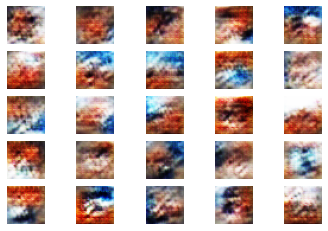

In [37]:
# load model
model = load_model('./{}'.format(MODEL_NAME))
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1] - Sigmoid
X = (X + 1) / 2.0


X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)